# MineCraft **旅行的时光**成就的最短路径

In [1]:
from PIL import Image
import numpy as np

image = Image.open('src/map.ppm')
image = np.array(image)
height, width = image.shape[:2]

colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)

首先载入地图，并观察不同生物群系的分布

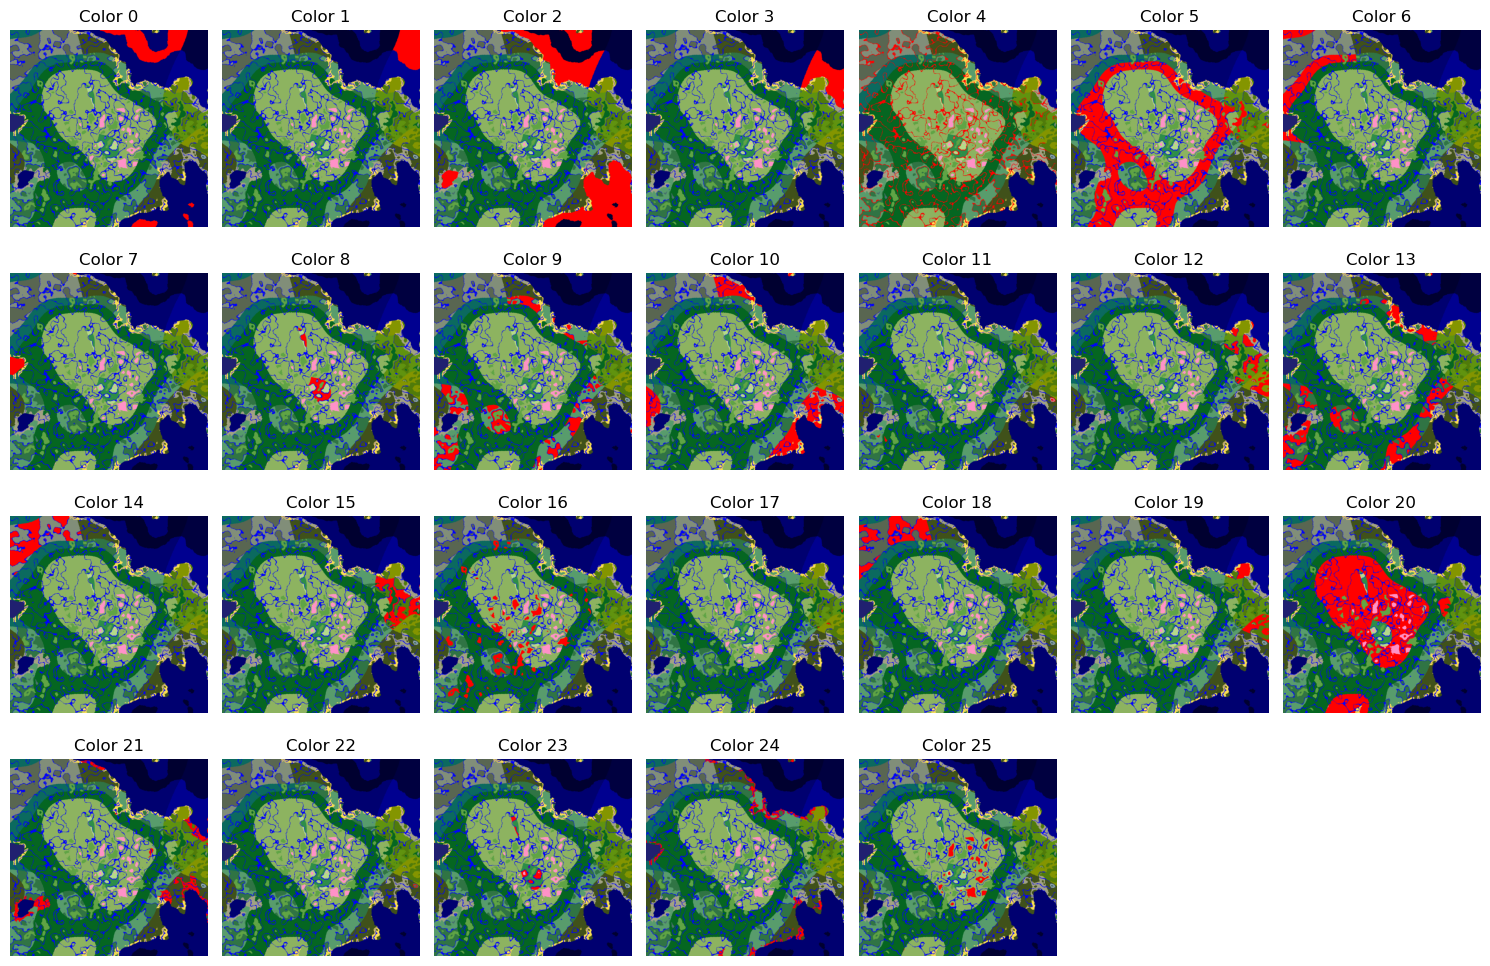

In [2]:
import matplotlib.pyplot as plt

def mark_color(image, color):
    image_marked = np.copy(image)
    image_marked[np.where((image == color).all(axis=2))] = [255, 0, 0]
    return image_marked

fig, ax = plt.subplots(len(colors) // 7 + 1, 7, figsize=(15, 10))
ax = ax.ravel()
for i, color in enumerate(colors):
    ax[i].imshow(mark_color(image, color))
    ax[i].set_title(f'Color {i}')
    ax[i].axis('off')

for j in range(i + 1, len(ax)):
    ax[j].set_visible(False)  # 将多余的子图隐藏
    
plt.tight_layout()
plt.show()

为了简化问题，将地图的粒度降低到区块级别，采用多数投票的方式来确定区块的生物群系。

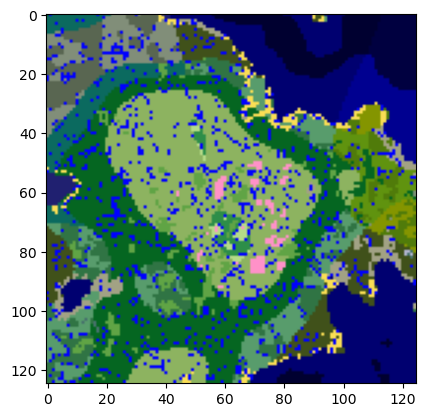

In [3]:
import numpy as np

def majority_vote_block(img, block_size=(16, 16)):
    h, w, c = img.shape
    new_h, new_w = h // block_size[0], w // block_size[1]
    result = np.zeros((new_h, new_w, c), dtype=img.dtype)

    for i in range(new_h):
        for j in range(new_w):
            block = img[i*block_size[0]:(i+1)*block_size[0], j*block_size[1]:(j+1)*block_size[1]].reshape(-1, c)
            _, count = np.unique(block, axis=0, return_counts=True)
            result[i, j] = block[np.argmax(count)]

    return result

chunked_image = majority_vote_block(image)
plt.imshow(chunked_image)

我们首先进行 K-Means 聚类，可以观察到生物群系有着明显的聚集效应。

进一步定义常见程度 $C(i)$：在给定区域内离群系 $i$ 的曼哈顿距离小于等于 $d_\text{lim}$ 的区块数占总区块数的比例。

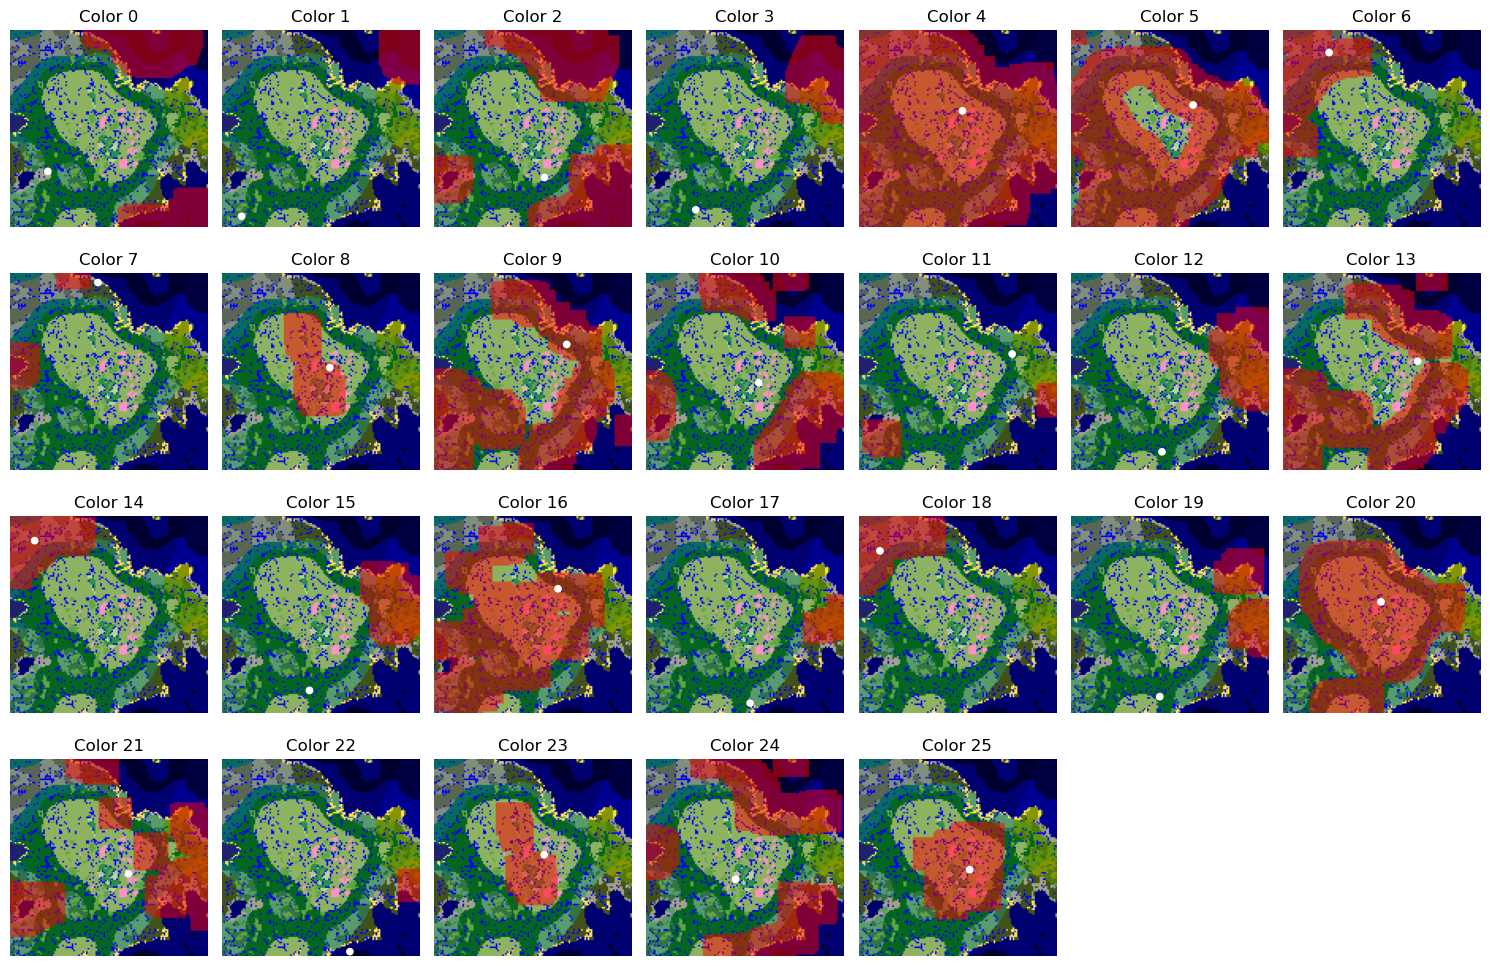

In [28]:
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.patches as patches
import warnings; warnings.simplefilter('ignore')

# 假设 image 是一个 numpy 数组，包含图像数据
# 假设 colors 是一个颜色列表，其中每个颜色是一个 (R, G, B) 元组
# 假设 d_lim 是距离限制

d_lim = 10
common_factors = []

height, width, _ = chunked_image.shape
fig, ax = plt.subplots(len(colors) // 7 + 1, 7, figsize=(15, 10))
ax = ax.ravel()

for i, color in tqdm(enumerate(colors), leave=False, total=len(colors)):

    # 找到所有匹配该颜色的像素点
    color_range = np.where((chunked_image == color).all(axis=2))
    if color_range[0].size == 0:
        continue

    # 创建一个空的遮罩
    mask = np.zeros((height, width), dtype=int)

    # 更新遮罩
    for x, y in zip(*color_range):
        x_min, x_max = max(0, int(x) - d_lim), min(height, int(x) + d_lim)
        y_min, y_max = max(0, int(y) - d_lim), min(width, int(y) + d_lim)
        mask[x_min:x_max, y_min:y_max] = 1

    # 计算遮罩中被标记的像素点占整个图像的比例
    factor = np.sum(mask) / (height * width)
    common_factors.append(factor)

    # 将像素点位置转换为聚类所需的数据格式
    pixel_positions = np.column_stack(color_range)

    # 使用 k-means 聚类
    # k = min(8, int(factor * 100))  # 动态确定 k 值
    # if k == 0:
    #     continue
    k = 1
    kmeans = KMeans(n_clusters=k).fit(pixel_positions)
    clusters = kmeans.cluster_centers_

    # 显示遮罩区域
    red_color = np.array([255, 0, 0])
    masked_image = np.where(mask[..., None] == 1, (red_color + chunked_image) // 2, chunked_image)
    for x, y in clusters:
        circ = patches.Circle((x, y), radius=2, color='white')
        ax[i].add_patch(circ)
    ax[i].imshow(masked_image)
    ax[i].set_title(f'Color {i}')
    ax[i].axis('off')

for j in range(i + 1, len(ax)):
    ax[j].set_visible(False)  # 将多余的子图隐藏
plt.tight_layout()
plt.show()

可视化不同群系的常见程度。可见差别是相当大的，这意味着可以优先满足稀有群系的访问，然后在常见群系中进一步优化路径。

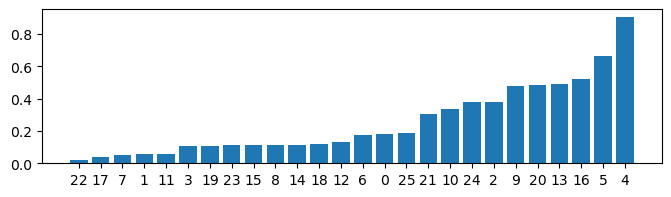

In [27]:
fig = plt.figure(figsize=(8, 2))
x = np.arange(len(colors))
order = np.argsort(common_factors)
plt.bar(order, np.sort(common_factors)[order])
plt.xticks(x, order)
plt.show()

为了进一步简化问题，可以尝试层次化的方式。将 $16\times16$ 个区块看作一个区域，统计每个区块中不同群系是否出现。

In [34]:
from collections import defaultdict

# chunked_image.shape is (height, width, 3)
field_height, field_width = chunked_image.shape[0] // 16, chunked_image.shape[1] // 16
field_counts = np.zeros((field_height, field_width, len(colors)), dtype=int)

for i in range(field_height):
    for j in range(field_width):
        field = chunked_image[i * 16: (i + 1) * 16, j * 16: (j + 1) * 16, :]
        biomes, counts = np.unique(field.reshape(-1, 3), axis=0, return_counts=True)
        field_counts[i, j, biomes] = counts

print(field_counts)

ValueError: shape mismatch: value array of shape (5,) could not be broadcast to indexing result of shape (5,3)